# Fraud Transactions Analysis  
## Step 3 - Exploratory Data Analysis (EDA)

Objectives:
- Understand transaction types
- Analyze fraud distribution
- Identify patterns in amounts and time
- Produce business insights

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.executable)

/Users/famoussounton/Documents/Portfolio projects/fraud-analysis/.venv/bin/python


In [3]:
import polars as pl
import matplotlib.pyplot as plt

In [4]:
df = pl.read_parquet("../data/clean.parquet")
df.shape

(6362620, 13)

In [5]:
df.head()

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_diff_orig,balance_diff_dest
i64,str,f64,str,f64,f64,str,f64,f64,i8,i8,f64,f64
132,"""CASH_OUT""",72967.59,"""C1892732017""",0.0,0.0,"""C403505142""",225090.22,298057.81,0,0,0.0,-72967.59
306,"""CASH_IN""",381563.82,"""C1384046267""",35263.0,416826.82,"""C880669936""",0.0,0.0,0,0,-381563.82,0.0
321,"""CASH_OUT""",207741.19,"""C23904956""",412336.0,204594.81,"""C1781755210""",532141.98,739883.17,0,0,207741.19,-207741.19
22,"""PAYMENT""",307.43,"""C993874853""",217938.0,217630.57,"""M1906834152""",0.0,0.0,0,0,307.43,0.0
181,"""CASH_IN""",85095.26,"""C2051096598""",58529.0,143624.26,"""C149067269""",171695.88,86600.62,0,0,-85095.26,85095.26


In [6]:
df.group_by("isFraud").len()

isFraud,len
i8,u32
1,8213
0,6354407


Observation:
Fraud represents less than 0.2% of all transactions (high class imbalance).

In [7]:
fraud_by_type = (
    df.group_by("type")
    .agg([
        pl.count().alias("total_tx"),
        pl.sum("isFraud").alias("fraud_tx")
    ])
)

fraud_by_type

/var/folders/45/yp28b0n94qzd27x5sy936t7w0000gn/T/ipykernel_38531/442086118.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_tx"),


type,total_tx,fraud_tx
str,u32,i64
"""CASH_OUT""",2237500,4116
"""PAYMENT""",2151495,0
"""TRANSFER""",532909,4097
"""DEBIT""",41432,0
"""CASH_IN""",1399284,0


In [8]:
fraud_by_type = fraud_by_type.with_columns(
    (pl.col("fraud_tx") / pl.col("total_tx") * 100)
    .round(2)
    .alias("fraud_rate")
)

fraud_by_type

type,total_tx,fraud_tx,fraud_rate
str,u32,i64,f64
"""CASH_OUT""",2237500,4116,0.18
"""PAYMENT""",2151495,0,0.0
"""TRANSFER""",532909,4097,0.77
"""DEBIT""",41432,0,0.0
"""CASH_IN""",1399284,0,0.0


Observation:
Almost all fraud occurs in TRANSFER and CASH_OUT transactions.

In [9]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


['type', 'total_tx', 'fraud_tx', 'fraud_rate']


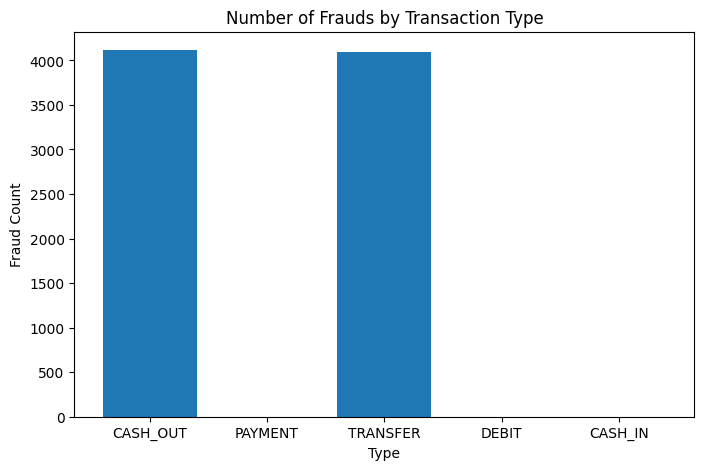

In [11]:
# Verify column names before plotting
print(fraud_by_type.columns)
# Convert and plot
fraud_by_type_pd = fraud_by_type.to_pandas()
plt.figure(figsize=(8,5))
plt.bar(fraud_by_type_pd["type"], fraud_by_type_pd["fraud_tx"])
plt.title("Number of Frauds by Transaction Type")
plt.xlabel("Type")
plt.ylabel("Fraud Count")
plt.show()

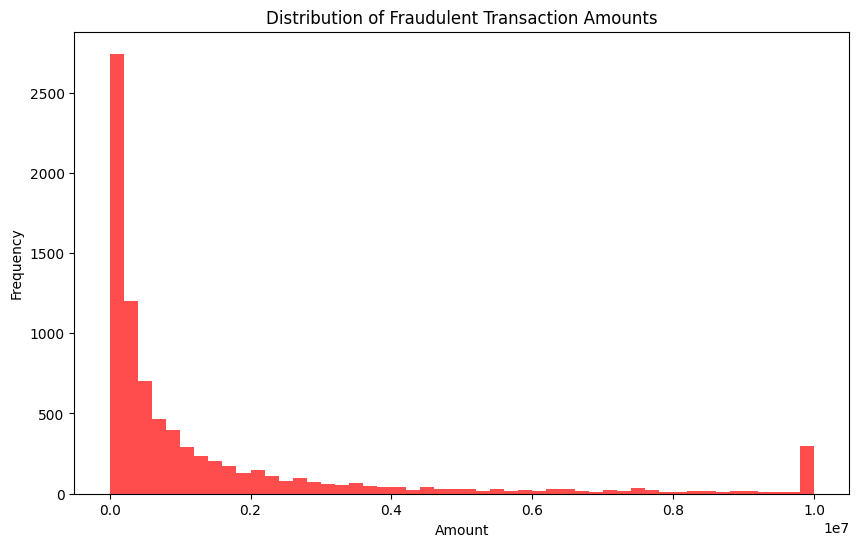

In [15]:
fraud_amounts = df.filter(pl.col("isFraud") == 1)["amount"]
plt.figure(figsize=(10, 6))
plt.hist(fraud_amounts, bins=50, color='red', alpha=0.7)
plt.title("Distribution of Fraudulent Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

Observation:
Fraudulent transactions usually involve high amounts.


In [16]:
fraud_by_step = (
    df.group_by("step")
    .agg(pl.sum("isFraud").alias("fraud_count"))
)

fraud_by_step.head()

step,fraud_count
i64,i64
268,6
414,16
417,6
676,8
18,16


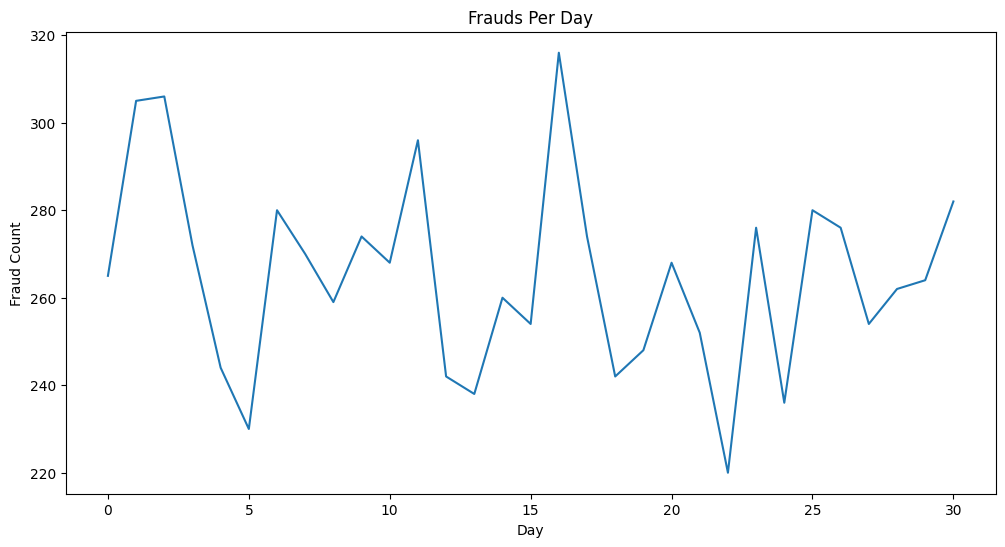

In [20]:
fraud_by_step_pd["day"] = fraud_by_step_pd["step"] // 24

fraud_by_day = (
    fraud_by_step_pd
    .groupby("day")["fraud_count"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
plt.plot(fraud_by_day["day"], fraud_by_day["fraud_count"])
plt.title("Frauds Per Day")
plt.xlabel("Day")
plt.ylabel("Fraud Count")
plt.show()

Observation:
Fraud occurs continuously over time without strong seasonality.